In [1]:
! pip install scikit-learn==0.23.2  # make sure sklearn of needed version is here
!pip install imbalanced-learn

     |████████████████████████████████| 6.8 MB 6.1 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import boto3
import numpy as np
import sagemaker
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import os
import joblib
from imblearn.under_sampling import RandomUnderSampler

import config

# get connection to s3 bucket
sm_boto3 = boto3.client('sagemaker')
sess = sagemaker.Session()
region = sess.boto_session.region_name

#bucket = sess.default_bucket()  # this could also be a hard-coded bucket name
bucket = config.bucket_name  # s3 with files

print('Using bucket ' + bucket)

Using bucket adsy-stock-ml


In [3]:
### Read Data
data_key = 'data/data.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

# Read in chunks
chunksize=200000 # load 200k rows max at once
dfs = []

for chunk in pd.read_csv(data_location, index_col=0, chunksize=chunksize):
    ## Date is not required. Remove rows where NA
    del chunk['date']  # del date
    chunk = chunk.drop(['deltawma', 'ticker'], axis =1, errors='ignore')  # delete extra columns
    chunk = chunk.drop(['high', 'low', 'open', 'close', 'index'], axis =1, errors='ignore')  # delete extra columns
    chunk = chunk.drop(['up_move', 'down_move', 'plus', 'minus'], axis =1, errors='ignore')  # delete extra columns
    chunk = chunk.dropna()  # drop NAs
    chunk = chunk.reset_index()  # reset index
    chunk.iloc[:, 0:30] = chunk.iloc[:, 0:30].astype(np.float32)  # convert all variables to float
    chunk['short_result'] = chunk['short_result'].astype(int)  # get predictable result back to int 
    dfs.append(chunk)
    
data = pd.concat(dfs)

del chunk
del dfs

In [4]:
# see data
data.head()

,index,volume,adj_close,sp_percent_change,percent_change,BASP_Buy.,BASP_Sell.,EMV_14_period_EMV.,VFI_VFI,EBBP_Bull.,...,MI_Mass_Index,ATR_14_period_ATR,DEMA_9_period_DEMA,ADX_14_period_ADX.,CMO_close,MFI_14_period_MFI,ROC_ROC,STOCHRSI_14_period_stochastic_RSI.,TRIX_20_period_TRIX,short_result
0,131.0,0.089324,0.014743,0.002114,0.020071,2.281912,0.883933,17.879332,-13.751639,0.043085,...,24.848562,0.049533,0.010353,21.227537,16.157206,55.607300,3.340595,0.577741,-0.040675,4
1,132.0,0.086843,0.016331,0.006539,0.012650,1.018420,0.442709,17.512634,-13.490209,0.043593,...,24.888653,0.045344,0.011764,22.396429,26.757608,55.615551,6.661732,0.583010,-0.025370,7
2,133.0,0.035531,0.015625,0.004401,-0.005552,0.036224,0.630014,17.299255,-14.395304,0.042363,...,24.895430,0.043678,0.006033,23.659956,26.890757,54.308846,4.751462,0.586596,-0.009206,9
3,134.0,0.056490,0.013244,0.009806,-0.018842,0.983848,0.939610,18.369110,-15.927130,0.023385,...,24.983444,0.045793,-0.002818,22.027960,34.821430,53.195400,1.443001,0.589106,0.005479,10
4,135.0,0.042874,0.012362,-0.001653,-0.007112,0.703391,0.143036,18.360376,-16.374107,0.002757,...,25.066467,0.046206,-0.004830,20.857468,23.502304,47.637695,1.361409,0.585321,0.018053,10


In [5]:
# get data info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2285502 entries, 0 to 103139
Data columns (total 23 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   index                               float32
 1   volume                              float32
 2   adj_close                           float32
 3   sp_percent_change                   float32
 4   percent_change                      float32
 5   BASP_Buy.                           float32
 6   BASP_Sell.                          float32
 7   EMV_14_period_EMV.                  float32
 8   VFI_VFI                             float32
 9   EBBP_Bull.                          float32
 10  EBBP_Bear.                          float32
 11  MACD_MACD                           float32
 12  ER_10_period_ER                     float32
 13  MI_Mass_Index                       float32
 14  ATR_14_period_ATR                   float32
 15  DEMA_9_period_DEMA                  float32
 16  A

In [6]:
# check for null values
data.isnull().sum()

index                                 0
volume                                0
adj_close                             0
sp_percent_change                     0
percent_change                        0
BASP_Buy.                             0
BASP_Sell.                            0
EMV_14_period_EMV.                    0
VFI_VFI                               0
EBBP_Bull.                            0
EBBP_Bear.                            0
MACD_MACD                             0
ER_10_period_ER                       0
MI_Mass_Index                         0
ATR_14_period_ATR                     0
DEMA_9_period_DEMA                    0
ADX_14_period_ADX.                    0
CMO_close                             0
MFI_14_period_MFI                     0
ROC_ROC                               0
STOCHRSI_14_period_stochastic_RSI.    0
TRIX_20_period_TRIX                   0
short_result                          0
dtype: int64

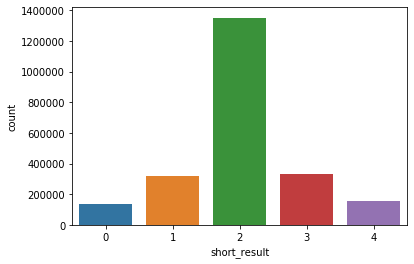

In [7]:
### Prepping data

## Creating bins for classes
# means strong sell=0, sell=1, hold=2. buy=3, strong buy=4
bins=[-100000, -11, -5, 5, 11, 100000]  # based on personal decision
group_names = [0, 1, 2, 3, 4]
data['short_result'] = pd.cut(data['short_result'], bins=bins, labels=group_names)  # cut data in bins

data['short_result'] = data['short_result'].astype(int)  # convert categories back to int

sns.countplot(data['short_result'])  # see the distribution of results

X = data.drop(['index'], axis=1, errors='ignore')  # remove index

del data

In [12]:
## Resampling data to deal with imbalance

rus = RandomUnderSampler()
X, y = rus.fit_resample(X.loc[:, X.columns != 'short_result'], X['short_result'])



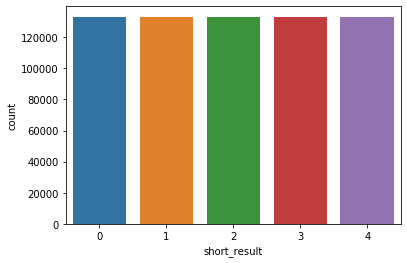

In [13]:
sns.countplot(y)  # see the distribution of balanced results

In [21]:
X.merge(pd.DataFrame(y), left_index=True, right_index=True)

,volume,adj_close,sp_percent_change,percent_change,BASP_Buy.,BASP_Sell.,EMV_14_period_EMV.,VFI_VFI,EBBP_Bull.,EBBP_Bear.,...,MI_Mass_Index,ATR_14_period_ATR,DEMA_9_period_DEMA,ADX_14_period_ADX.,CMO_close,MFI_14_period_MFI,ROC_ROC,STOCHRSI_14_period_stochastic_RSI.,TRIX_20_period_TRIX,short_result
0,0.034421,0.023123,-0.000838,-0.008491,0.394296,0.616505,17.148661,-6.399660,0.035140,0.000752,...,24.141071,0.033647,0.001953,38.198002,51.388889,57.085541,4.258242,0.700734,0.185495,0
1,0.014270,0.023211,0.005428,-0.001971,0.180192,0.414363,16.882061,-3.227430,0.022465,0.000476,...,23.895252,0.029294,-0.000543,41.760223,41.605839,65.335960,5.559416,0.712624,0.231022,0
2,0.146130,0.050213,0.006930,-0.002213,1.783242,0.966713,16.397985,9.929570,0.021090,0.000374,...,25.155720,0.059969,-0.003490,43.247894,-36.956520,66.475273,-3.376206,0.756177,0.536821,0
3,0.067262,0.059499,0.007320,0.036413,1.371634,0.092437,22.465750,10.509474,0.054031,0.000945,...,25.333593,0.043810,0.016457,40.878433,36.134453,41.311600,1.924105,0.708592,0.546523,0
4,0.127743,0.063428,0.003047,0.023072,2.486806,0.831257,25.148279,11.379224,0.073294,0.001265,...,25.663691,0.046759,0.019787,42.471001,73.839661,51.481098,5.802603,0.706536,0.553636,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665560,0.003183,0.018666,-0.004440,0.034286,0.209433,0.520769,33.088100,22.022968,0.014148,0.001551,...,25.339523,0.060221,-0.001139,26.308266,-24.355280,49.529766,-0.440044,0.528219,-0.036681,4
665561,0.047196,0.013334,-0.003018,-0.156070,1.690982,2.225790,0.199541,-19.153294,-0.290722,-0.069189,...,24.523151,0.333649,-0.109265,58.178749,-40.384617,13.417515,-57.372261,0.252480,-1.456745,4
665562,0.050927,0.162533,-0.006696,0.019482,1.343658,0.899889,43.036701,-21.810797,0.000057,0.000002,...,24.394556,0.048768,0.006988,28.308830,-26.535639,34.535126,-5.608788,0.373645,-0.610416,4
665563,0.010115,0.027926,-0.022505,-0.101351,1.863893,5.864914,11.897565,1.818952,0.033644,0.004563,...,25.623251,0.075403,-0.041637,38.942680,-72.350250,28.321487,-19.491526,0.528146,0.395690,4


In [8]:
## Split to train and test set
train_ratio = 0.98
validation_ratio = 0.01
test_ratio = 0.01

# Split once for training set
train, test = train_test_split(X, test_size=1 - train_ratio)

# Split again for test & validaition
val, test = train_test_split(test, test_size=test_ratio/(test_ratio + validation_ratio)) 


del X

In [9]:
## Fit data to standard distribution 
sc = StandardScaler()
train.loc[:, train.columns != 'short_result'] = sc.fit_transform(train.loc[:, train.columns != 'short_result'] )  # scale based on training data
test.loc[:, test.columns != 'short_result'] = sc.transform(test.loc[:, test.columns != 'short_result'])  # test data is transformed based on raining data
val.loc[:, val.columns != 'short_result'] = sc.transform(val.loc[:, val.columns != 'short_result'])  # validation data is transformed based on raining data
joblib.dump(sc, 'scaler.gz')  # dump scaler to use it later for predicting

['scaler.gz']

In [10]:
# store data temporary in h5 format
train.to_hdf('train.h5', key='train', mode='w')
test.to_hdf('test.h5', key='test', mode='w')
val.to_hdf('val.h5', key='val', mode='w')

In [11]:
# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path='train.h5', bucket=bucket,
    key_prefix='data/train')

testpath = sess.upload_data(
    path='test.h5', bucket=bucket,
    key_prefix='data/test')

valpath = sess.upload_data(
    path='val.h5', bucket=bucket,
    key_prefix='data/val')

scaler = sess.upload_data(
    path="scaler.gz", bucket=bucket,
    key_prefix='pickles')

In [12]:
# remove local temp files
os.remove('train.h5')
os.remove('test.h5')
os.remove('val.h5')
os.remove('scaler.gz')